In [1]:
import numpy as np
import torch
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np 
import math 
from skimage.io import imread, imshow
import os
import cv2
import seaborn as sns

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


C:\Users\ASUS\anaconda3\envs\pytorch\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


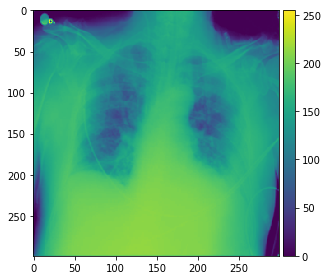

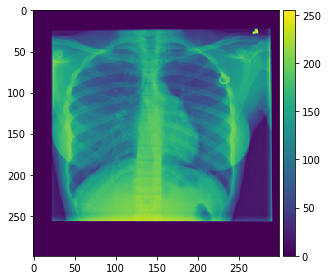

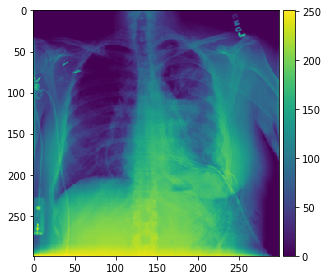

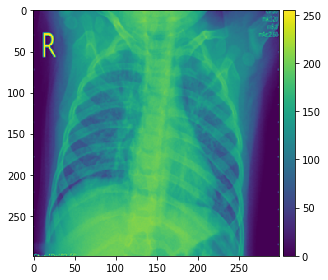

In [3]:
path_Covid = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\Clasificador\Dataset 3\COVID' 
path_Normal = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\Clasificador\Dataset 3\Normal'
path_Lung_Opacity = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\Clasificador\Dataset 3\Lung_Opacity'
path_Viral_Pneumonia = r'C:\Users\ASUS\Desktop\UTEC\Redes Neuronales (CNN)\Clasificador\Dataset 3\Viral Pneumonia'

#### Funcion para leer imagenes dentro de una carpeta
width = 299
height = 299
def imageReading (path):
    folderFilesids = os.listdir(path)
    images = np.zeros((len(folderFilesids), height, width))
    for count, n in enumerate(folderFilesids):
        path1 = path + '\\' + n
        originalImage = imread(path1)
        if (len(originalImage.shape)==2):
            originalImage = imread(path1)[:,:]
        if (len(originalImage.shape)==3):
            originalImage = imread(path1)[:,:,0]
        #print(originalImage.shape)
        images[count] = originalImage
    imshow(images[0])
    plt.show()
    return images
covid = imageReading(path_Covid)
normal = imageReading(path_Normal)
Lung_Opacity = imageReading(path_Lung_Opacity)
Viral_Pneumonia = imageReading(path_Viral_Pneumonia)
nombres = ['Covid', 'Normal', 'Lung_Opacity', 'Viral_Pneumonia']

### Separamos la data la etiquetamos normalizamos y cargamos por un batch

In [4]:
covid = torch.from_numpy(np.array(covid).reshape(-1,1,299,299)) ## torch se convierte nuestra data en tensor - Aumenta la dimension.
normal = torch.from_numpy(np.array(normal).reshape(-1,1,299,299)) # (-1: Cantidad de imagenes, 1: gris o color, 299 x 299: tamaño de la imagen
Lung_Opacity = torch.from_numpy(np.array(Lung_Opacity).reshape(-1,1,299,299))
Viral_Pneumonia = torch.from_numpy(np.array(Viral_Pneumonia).reshape(-1,1,299,299))

img_covidlist = []
for i in range(covid.shape[0]):
      img_covidlist.append((covid[i]/255.0,0.0))

img_normallist = []
for i in range(normal.shape[0]):
      img_normallist.append((normal[i]/255.0,1.0))
        
img_Lung_Opacitylist = []
for i in range(Lung_Opacity.shape[0]):
      img_Lung_Opacitylist.append((Lung_Opacity[i]/255.0,2.0))
    
img_Viral_Pneumonialist = []
for i in range(Viral_Pneumonia.shape[0]):
      img_Viral_Pneumonialist.append((Viral_Pneumonia[i]/255.0,3.0))

import random
random.shuffle(img_covidlist)
covid_train = img_covidlist[0:int(len(img_covidlist)*0.7)]
covid_validation = img_covidlist[int(len(img_covidlist)*0.7):int(len(img_covidlist)*0.9)]
covid_test = img_covidlist[int(len(img_covidlist)*0.9):]

random.shuffle(img_normallist)
normal_train = img_normallist[0:int(len(img_normallist)*0.7)]
normal_validation = img_normallist[int(len(img_normallist)*0.7):int(len(img_normallist)*0.9)]
normal_test = img_normallist[int(len(img_normallist)*0.9):]

random.shuffle(img_Lung_Opacitylist)
Lung_Opacitylist_train = img_Lung_Opacitylist[0:int(len(img_Lung_Opacitylist)*0.7)]
Lung_Opacitylist_validation = img_Lung_Opacitylist[int(len(img_Lung_Opacitylist)*0.7):int(len(img_Lung_Opacitylist)*0.9)]
Lung_Opacitylist_test = img_Lung_Opacitylist[int(len(img_Lung_Opacitylist)*0.9):]

random.shuffle(img_Viral_Pneumonialist)
Viral_Pneumonialist_train = img_Viral_Pneumonialist[0:int(len(img_Viral_Pneumonialist)*0.7)]
Viral_Pneumonialist_validation = img_Viral_Pneumonialist[int(len(img_Viral_Pneumonialist)*0.7):int(len(img_Viral_Pneumonialist)*0.9)]
Viral_Pneumonialist_test = img_Viral_Pneumonialist[int(len(img_Viral_Pneumonialist)*0.9):]


train_beta = covid_train + normal_train + Lung_Opacitylist_train + Viral_Pneumonialist_train
validation_beta = covid_validation + normal_validation + Lung_Opacitylist_validation + Viral_Pneumonialist_validation
test_beta = covid_test + normal_test + Lung_Opacitylist_test + Viral_Pneumonialist_test

batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=train_beta, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_beta, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_beta, batch_size=batch_size, shuffle=True)

### Arquitectura del modelo

### Modelo 1 AlexNet con Dropout en cada capa

In [5]:
torch.manual_seed(22)
#hyperparameter 
num_classes = 4
learning_rate =  0.001
num_epochs = 20

class CNN1(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN1, self).__init__()
        #input 299x299
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=24, kernel_size=11, stride=4, padding=0), #73 x 73
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2,padding=1)) #36 x 36
        self.layer2 = nn.Sequential(
            nn.Conv2d(24, 64, kernel_size=3, stride=2, padding=0),  #18x18
            nn.BatchNorm2d(64),  #18x18
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),  #18x18
            nn.BatchNorm2d(96),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1),  #18x18
            nn.BatchNorm2d(96),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(96, 64, kernel_size=3, stride=1, padding=1),  #18x18
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=4, padding=1))     
        self.fc1 = nn.Linear(5*5*64, 5*5*64)
        self.fc2 = nn.Linear(5*5*64, num_classes)
                      
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out 

### Modelo 2 AlexNet

In [6]:
torch.manual_seed(22)
#hyperparameter 
num_classes = 4
learning_rate =  0.001
num_epochs = 20

class CNN2(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN2, self).__init__()
        #input 299x299
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=24, kernel_size=11, stride=4, padding=0), #73 x 73
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2,padding=1)) #36 x 36
        self.layer2 = nn.Sequential(
            nn.Conv2d(24, 64, kernel_size=3, stride=2, padding=0),  #18x18
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),  #18x18
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1),  #18x18
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(96, 64, kernel_size=3, stride=1, padding=1),  #18x18
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=4, padding=1))
        self.fc1 = nn.Linear(5*5*64, 5*5*64)
        self.fc2 = nn.Linear(5*5*64, num_classes)
                      
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out 

### Modelo 3 

In [7]:
torch.manual_seed(22)
#hyperparameter 
num_classes = 4
learning_rate =  0.001
num_epochs = 20

class CNN3(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN3, self).__init__()
        #input 299x299
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=24, kernel_size=11, stride=4, padding=0), #73 x 73
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2,padding=1), #36 x 36
            nn.Dropout(p=0.8))
        self.layer2 = nn.Sequential(
            nn.Conv2d(24, 64, kernel_size=3, stride=2, padding=0),  #18x18
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Dropout(p=0.2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),  #18x18
            nn.BatchNorm2d(96),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1),  #18x18
            nn.BatchNorm2d(96),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(96, 64, kernel_size=3, stride=1, padding=1),  #18x18
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=4, padding=1),
            nn.Dropout(p=0.2))
        self.fc1 = nn.Linear(5*5*64, 5*5*64)
        self.fc2 = nn.Linear(5*5*64, num_classes)
                      
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out 

### Modelo 4

In [8]:
torch.manual_seed(22)
#hyperparameter 
num_classes = 4
learning_rate =  0.001
num_epochs = 20

class CNN4(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN4, self).__init__()
        #input 299x299
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=24, kernel_size=11, stride=4, padding=0), #73 x 73
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride=2,padding=1), #36 x 36
            nn.Dropout(p=0.8))
        self.layer2 = nn.Sequential(
            nn.Conv2d(24, 64, kernel_size=3, stride=2, padding=0),  #18x18
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Dropout(p=0.2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 96, kernel_size=3, stride=1, padding=1),  #18x18
            nn.BatchNorm2d(96),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(96, 96, kernel_size=3, stride=1, padding=1),  #18x18
            nn.BatchNorm2d(96),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(96, 64, kernel_size=3, stride=1, padding=1),  #18x18
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=4, padding=1),
            nn.Dropout(p=0.2))
        self.fc1 = nn.Linear(5*5*64, 5*5*64)
        self.fc2 = nn.Linear(5*5*64, 5*5*64)
        self.fc3 = nn.Linear(5*5*64, num_classes)
                      
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out 

In [9]:
def train(model, optimizer, loos_fn, num_epochs):
    loss_vals = []
    running_loss =0.0
    # train the model
    total_step = len(train_loader)  # el train loader es el motor que se encarga de sacar las imagenes del train_set

    list_loss_train= []
    list_loss_validation = []
    list_time = []
    j=0
    
    best_loss = 0
    
    # Train the model
    for epoch in range(num_epochs):
        train_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            images = images.float().to(device)
            labels = labels.long().to(device)
            # forward 
            output = model(images).float()
            #Calucla el loss
            loss   = loss_fn(output, labels)
            # change the params
            # Clear the gradients of all optimized variables
            optimizer.zero_grad()
            # Backward 
            loss.backward()
            #parametros update
            optimizer.step()
            train_loss +=loss.item()
            list_time.append(j)
            j+=1

            if (i+1) % 100 == 0:
                  print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                    
        list_loss_train.append(train_loss / len(train_loader))
        
        #validation of the model
        valid_loss =0.0   
        for i, (images, labels) in enumerate(test_loader):
            images = images.float().to(device)
            labels = labels.long().to(device)
            
            # Forward Pass
            output = model(images).float()
            # Find the Loss
            loss   = loss_fn(output, labels)
            # Calculate loss
            valid_loss +=loss.item()
        #Save loss in a List
        
        list_loss_validation.append(valid_loss / len(test_loader))
        ###Early stopping###
        if valid_loss > best_loss:
            best_loss = valid_loss
            # At this point also save a snapshot of the current model
            torch.save(model, 'my_model_best_loss.pth')
        
        print(f'Epoch {epoch+1} Training Loss: {train_loss / len(train_loader)} Validation Loss: {valid_loss / len(validation_loader)}')  
    
    print('Finished Training Trainset')
    return list_loss_train,list_loss_validation, best_loss, model

### Modelo 1 con batchnormalization

In [10]:
model         = CNN1(num_classes).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)

print([e.shape for e in model.fc2.parameters()])

[torch.Size([4, 1600]), torch.Size([4])]


In [11]:
%%time
list_loss_train,list_loss_validation, best_loss, model = train(model,optimizer,loss_fn, num_epochs=50)

Epoch [1/50], Step [100/175], Loss: 0.6967
Epoch 1 Training Loss: 1.0527765913520541 Validation Loss: 0.24189113676548005
Epoch [2/50], Step [100/175], Loss: 0.6098
Epoch 2 Training Loss: 0.47115922374384744 Validation Loss: 0.16158573880791663
Epoch [3/50], Step [100/175], Loss: 0.7119
Epoch 3 Training Loss: 0.5197331348913057 Validation Loss: 0.18026156455278397
Epoch [4/50], Step [100/175], Loss: 0.9334
Epoch 4 Training Loss: 0.4145454788208008 Validation Loss: 0.14944991558790208
Epoch [5/50], Step [100/175], Loss: 0.5184
Epoch 5 Training Loss: 0.36794427288430076 Validation Loss: 0.16702550336718558
Epoch [6/50], Step [100/175], Loss: 0.3084
Epoch 6 Training Loss: 0.33955712663275855 Validation Loss: 0.18889888018369674
Epoch [7/50], Step [100/175], Loss: 0.7927
Epoch 7 Training Loss: 0.33020241490432195 Validation Loss: 0.16498965103179217
Epoch [8/50], Step [100/175], Loss: 0.6072
Epoch 8 Training Loss: 0.29409083738923075 Validation Loss: 0.14688099719583989
Epoch [9/50], Step 

In [12]:
with torch.no_grad():
    y_true = []
    y_pred = []  
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.float().to(device), labels.float().to(device)           
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        y_true.append(labels.cpu().data.numpy()) 
        y_pred.append(predicted.cpu().data.numpy())  
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'.format(len(test_beta), 100 * correct / total))

Test Accuracy of the model on the 400 test images: 90.5 %


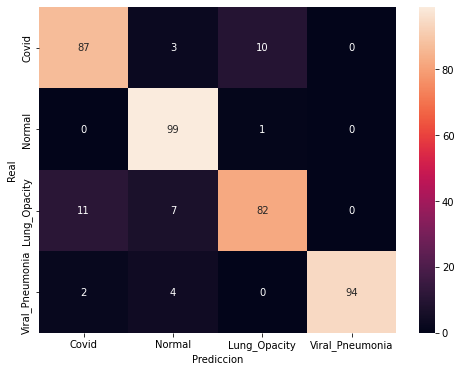

In [13]:
from sklearn.metrics import confusion_matrix
import itertools

confusion_matrix_modelo1=confusion_matrix(list(itertools.chain(*y_true)), list(itertools.chain(*y_pred)))
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_modelo1, xticklabels=nombres, yticklabels=nombres, annot =True, fmt= 'd')
plt.xlabel('Prediccion')
plt.ylabel('Real')
plt.show()

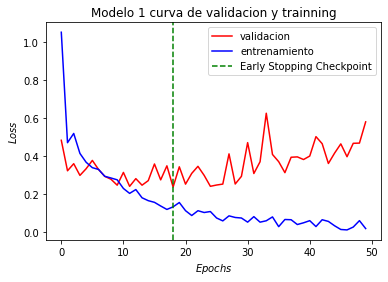

In [14]:
import matplotlib.pyplot as plt
f = plt.figure()
plt.plot( list_loss_validation, '-r', label="validacion")
plt.plot( list_loss_train, '-b', label="entrenamiento")
# find position of lowest validation loss
minposs = list_loss_validation.index(min(list_loss_validation)) 
plt.axvline(minposs, linestyle='--', color='g',label='Early Stopping Checkpoint')

plt.ylabel('$Loss$')
plt.xlabel('$Epochs$')
plt.title('Modelo 1 curva de validacion y trainning')
plt.legend()
plt.show()

### Modelo 2 sin ajuste

In [15]:
model         = CNN2(num_classes).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)

print([e.shape for e in model.fc2.parameters()])

[torch.Size([4, 1600]), torch.Size([4])]


In [16]:
%%time
list_loss_train,list_loss_validation, best_loss, model = train(model,optimizer,loss_fn, num_epochs=50)

Epoch [1/50], Step [100/175], Loss: 0.6471
Epoch 1 Training Loss: 1.0051592338085173 Validation Loss: 0.3143013060092926
Epoch [2/50], Step [100/175], Loss: 0.3429
Epoch 2 Training Loss: 0.5761895841360092 Validation Loss: 0.21546056985855103
Epoch [3/50], Step [100/175], Loss: 0.2435
Epoch 3 Training Loss: 0.4561675854240145 Validation Loss: 0.19236413955688478
Epoch [4/50], Step [100/175], Loss: 0.3650
Epoch 4 Training Loss: 0.4505307588832719 Validation Loss: 0.1954565453529358
Epoch [5/50], Step [100/175], Loss: 0.4330
Epoch 5 Training Loss: 0.3724191818067006 Validation Loss: 0.16806394904851912
Epoch [6/50], Step [100/175], Loss: 0.7464
Epoch 6 Training Loss: 0.3658965252126966 Validation Loss: 0.16124237626791
Epoch [7/50], Step [100/175], Loss: 0.1250
Epoch 7 Training Loss: 0.3483752425653594 Validation Loss: 0.15673895478248595
Epoch [8/50], Step [100/175], Loss: 0.1220
Epoch 8 Training Loss: 0.30335268740143095 Validation Loss: 0.1800437468290329
Epoch [9/50], Step [100/175],

In [17]:
with torch.no_grad():
    y_true = []
    y_pred = []  
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.float().to(device), labels.float().to(device)           
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        y_true.append(labels.cpu().data.numpy()) 
        y_pred.append(predicted.cpu().data.numpy())  
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'.format(len(test_beta), 100 * correct / total))

Test Accuracy of the model on the 400 test images: 89.75 %


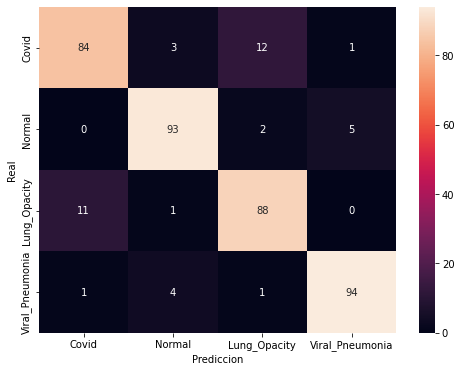

In [18]:
from sklearn.metrics import confusion_matrix
import itertools

confusion_matrix_modelo2=confusion_matrix(list(itertools.chain(*y_true)), list(itertools.chain(*y_pred)))
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_modelo2, xticklabels=nombres, yticklabels=nombres, annot =True, fmt= 'd')
plt.xlabel('Prediccion')
plt.ylabel('Real')
plt.show()

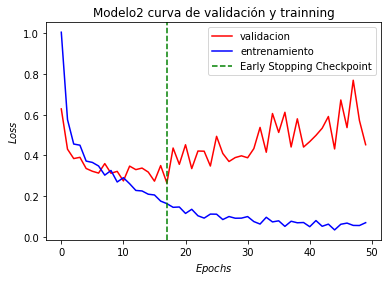

In [19]:
import matplotlib.pyplot as plt
f = plt.figure()
plt.plot( list_loss_validation, '-r', label="validacion")
plt.plot( list_loss_train, '-b', label="entrenamiento")
# find position of lowest validation loss
minposs = list_loss_validation.index(min(list_loss_validation)) 
plt.axvline(minposs, linestyle='--', color='g',label='Early Stopping Checkpoint')

plt.ylabel('$Loss$')
plt.xlabel('$Epochs$')
plt.title('Modelo2 curva de validación y trainning')
plt.legend()
plt.show()

### Modelo 3 Con BatchNormalization + con Dropout

In [20]:
model         = CNN3(num_classes).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)

print([e.shape for e in model.fc2.parameters()])

[torch.Size([4, 1600]), torch.Size([4])]


In [21]:
%%time
list_loss_train,list_loss_validation, best_loss, model = train(model,optimizer,loss_fn, num_epochs=50)

Epoch [1/50], Step [100/175], Loss: 0.4000
Epoch 1 Training Loss: 1.3155986719472068 Validation Loss: 0.27142785549163817
Epoch [2/50], Step [100/175], Loss: 0.5365
Epoch 2 Training Loss: 0.6540114762101854 Validation Loss: 0.29790835797786713
Epoch [3/50], Step [100/175], Loss: 1.1042
Epoch 3 Training Loss: 0.6041850398693766 Validation Loss: 0.26637022733688354
Epoch [4/50], Step [100/175], Loss: 0.3903
Epoch 4 Training Loss: 0.6004986919675555 Validation Loss: 0.35306808531284334
Epoch [5/50], Step [100/175], Loss: 0.4619
Epoch 5 Training Loss: 0.5641256263000625 Validation Loss: 0.200984103679657
Epoch [6/50], Step [100/175], Loss: 0.7475
Epoch 6 Training Loss: 0.5259684737665312 Validation Loss: 0.1876362270116806
Epoch [7/50], Step [100/175], Loss: 0.3918
Epoch 7 Training Loss: 0.48295894495078495 Validation Loss: 0.20492201790213585
Epoch [8/50], Step [100/175], Loss: 0.6729
Epoch 8 Training Loss: 0.45966253536088125 Validation Loss: 0.223684963285923
Epoch [9/50], Step [100/175

In [22]:
with torch.no_grad():
    y_true = []
    y_pred = []  
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.float().to(device), labels.float().to(device)           
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        y_true.append(labels.cpu().data.numpy()) 
        y_pred.append(predicted.cpu().data.numpy())  
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'.format(len(test_beta), 100 * correct / total))

Test Accuracy of the model on the 400 test images: 89.25 %


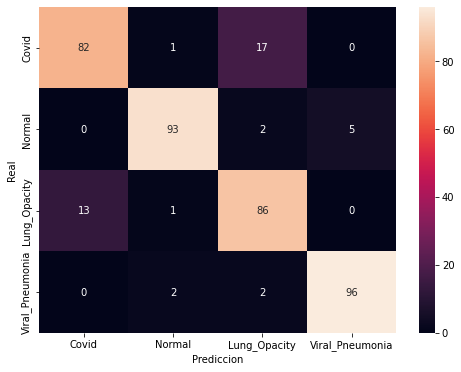

In [23]:
from sklearn.metrics import confusion_matrix
import itertools

confusion_matrix_modelo3=confusion_matrix(list(itertools.chain(*y_true)), list(itertools.chain(*y_pred)))
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_modelo3, xticklabels=nombres, yticklabels=nombres, annot =True, fmt= 'd')
plt.xlabel('Prediccion')
plt.ylabel('Real')
plt.show()

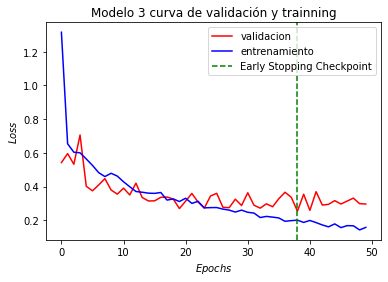

In [24]:
import matplotlib.pyplot as plt
f = plt.figure()
plt.plot( list_loss_validation, '-r', label="validacion")
plt.plot( list_loss_train, '-b', label="entrenamiento")
# find position of lowest validation loss
minposs = list_loss_validation.index(min(list_loss_validation)) 
plt.axvline(minposs, linestyle='--', color='g',label='Early Stopping Checkpoint')

plt.ylabel('$Loss$')
plt.xlabel('$Epochs$')
plt.title('Modelo 3 curva de validación y trainning')
plt.legend()
plt.show()

### Modelo 4 Aumentando una full connected adicional

In [25]:
model         = CNN4(num_classes).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)

print([e.shape for e in model.fc3.parameters()])

[torch.Size([4, 1600]), torch.Size([4])]


In [26]:
%%time
list_loss_train,list_loss_validation, best_loss, model = train(model,optimizer,loss_fn, num_epochs=50)

Epoch [1/50], Step [100/175], Loss: 1.0671
Epoch 1 Training Loss: 1.66602766088077 Validation Loss: 0.33416705071926117
Epoch [2/50], Step [100/175], Loss: 0.3777
Epoch 2 Training Loss: 0.6974844257320677 Validation Loss: 0.3083001017570496
Epoch [3/50], Step [100/175], Loss: 0.4496
Epoch 3 Training Loss: 0.6365616865668978 Validation Loss: 0.25340926736593244
Epoch [4/50], Step [100/175], Loss: 0.7443
Epoch 4 Training Loss: 0.6076269471645355 Validation Loss: 0.2618067893385887
Epoch [5/50], Step [100/175], Loss: 1.0540
Epoch 5 Training Loss: 0.5678469845226832 Validation Loss: 0.24904522567987442
Epoch [6/50], Step [100/175], Loss: 0.2013
Epoch 6 Training Loss: 0.5563500089517661 Validation Loss: 0.3058964306116104
Epoch [7/50], Step [100/175], Loss: 0.4927
Epoch 7 Training Loss: 0.5875567803638322 Validation Loss: 0.26282980471849443
Epoch [8/50], Step [100/175], Loss: 0.4840
Epoch 8 Training Loss: 0.51927779512746 Validation Loss: 0.23417648136615754
Epoch [9/50], Step [100/175], L

In [27]:
with torch.no_grad():
    y_true = []
    y_pred = []  
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.float().to(device), labels.float().to(device)           
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        y_true.append(labels.cpu().data.numpy()) 
        y_pred.append(predicted.cpu().data.numpy())  
        correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the {} test images: {} %'.format(len(test_beta), 100 * correct / total))

Test Accuracy of the model on the 400 test images: 88.5 %


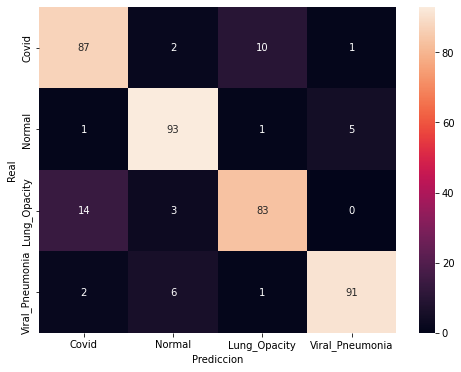

In [31]:
from sklearn.metrics import confusion_matrix
import itertools

confusion_matrix_modelo4=confusion_matrix(list(itertools.chain(*y_true)), list(itertools.chain(*y_pred)))
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix_modelo4, xticklabels=nombres, yticklabels=nombres, annot =True, fmt= 'd')
plt.xlabel('Prediccion')
plt.ylabel('Real')
plt.show()

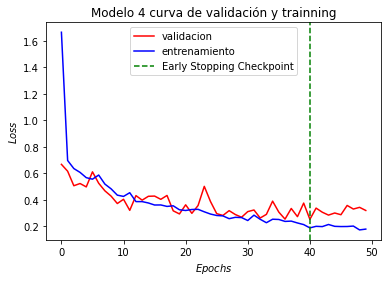

In [32]:
import matplotlib.pyplot as plt
f = plt.figure()
plt.plot( list_loss_validation, '-r', label="validacion")
plt.plot( list_loss_train, '-b', label="entrenamiento")
# find position of lowest validation loss
minposs = list_loss_validation.index(min(list_loss_validation)) 
plt.axvline(minposs, linestyle='--', color='g',label='Early Stopping Checkpoint')

plt.ylabel('$Loss$')
plt.xlabel('$Epochs$')
plt.title('Modelo 4 curva de validación y trainning')
plt.legend()
plt.show()